# Kombinowanie modeli

<h1 id=tocheading>Spis treści</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# -*- coding: utf-8 -*-
"""
Demo of unicode support in text and labels.
"""
from __future__ import unicode_literals
from __future__ import print_function
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from sklearn.cross_validation import StratifiedKFold, KFold, train_test_split
from sklearn.datasets import load_svmlight_file, load_boston
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix
from sklearn import preprocessing
from sklearn.datasets import load_boston, load_diabetes, load_linnerud, make_regression
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3, make_sparse_uncorrelated
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [4]:
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples, completeness_contamination

## Bootstrap i maximum likelihood
* bootstrap jest metodą uzyskiwania lepszej ewaluacji jakości modelu
  * losowanie ze zwracaniem zbiorów _bootstrap_ 
  * tworzenie nowych modeli dla każdego z nich
  * odpowiednie uśrednianie statystyk co daje lepszą ewaluację błędu i jego wariancji
  
* maximum likelihood jest podejściem optymalizacji
  * dla danych $D$
  * szukamy modelu, dla którego prawdopodobieństwo danych $D$ jest największe


### Określanie przedziałów ufności dla modeli liniowych


#### wykorzystanie błędu standardowego
* model liniowy z funkcjami bazowymi
  * $H$ macierzą $K$ funkcji bazowych $N$ przykładów
  * aproksymacja modelem liniowym daje zestaw paramaterów modelu $\hat{\theta}$
  * kowariancja $\hat{\theta}$ jest określona jako $$var(\hat{\theta})=(H^TH)^{-1}\hat{\sigma}^2$$ gdzie $\hat{\sigma}^2$ jest błędem kwadratowym aproksymacji
  * dla każdego przykładu błąd standardowy jest określony przez $$\widehat{std}(\hat{y}x)=[h(x)^T(H^TH)^{-1}h(x)]^{1/2}\hat{\sigma}$$
  * przedział $$\hat{y}(x)\pm 1.96 \widehat{std}(\hat{y}(x))$$
  
  
#### wykorzystanie metodologii bootstrap
  * wylosowanie $B=200$ zbiorów boostrap
  * wzięcie jako przedziału 5-tej najmniejszej i 5-tej najwiekszej wartości daje przedział 95 procentowej ufności
  
  

In [4]:
def draw_bootstrap(X, y):
    select = np.random.choice(np.arange(X.shape[0]), size=X.shape[0], replace=True)
    return X[select, :], y[select]

In [5]:
class Gaussians_data():
    def __init__(self, n_gaussians=5):
        self.n_gaussians = n_gaussians
        self.basis_mu = np.zeros((n_gaussians))
        self.basis_sigma = 1.
    def gaussian_basis(self, x, mu, sigma):
        return np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    def fit_transform(self, X):
        # TODO rozszerzyć do więcej niż jednego wymiaru
        mm = np.zeros((2, 1))
        mm[0, 0] = np.min(X)
        mm[1, 0] = np.max(X)
        ext = (mm[1, 0] - mm[0, 0]) / float(self.n_gaussians)
        mm[0, 0] -= ext /2.; mm[1, 0] += ext / 2.
        self.basis_mu = np.linspace(mm[0, 0], mm[1, 0], self.n_gaussians + 2)[1:-1]
        self.basis_sigma = 1. * (self.basis_mu[1] - self.basis_mu[0])
        # transformacja danych
        X_trans = np.zeros((X.shape[0], self.n_gaussians))
        for i in range(self.n_gaussians):
            X_trans[:, i] = self.gaussian_basis(X, self.basis_mu[i], 
                                                self.basis_sigma).reshape((X.shape[0],))
        return X_trans
    def transform(self, X):
        X_trans = np.zeros((X.shape[0], self.n_gaussians))
        for i in range(self.n_gaussians):
            X_trans[:, i] = self.gaussian_basis(X[:, 0], self.basis_mu[i], 
                                                self.basis_sigma).reshape((X.shape[0],))
        return X_trans
    def get_params(self):
        return self.basis_mu, self.basis_sigma

In [12]:
def bootstrap_inference(n_gaussians=5, n_exmpl=100, std=0.1, bootstrap_runs=10):
    left = -1.0; right = 1.0
    X = np.array(sorted(np.random.uniform(left, right, size=n_exmpl))).reshape((n_exmpl, 1))
    noise = np.random.normal(loc=0.0, scale=std, size=n_exmpl)
    y = 2. * X ** 4 + 6.5 * X ** 3 + 0.5 * X ** 2 - 4. * X 
    y = y + noise.reshape((n_exmpl, 1))
    y = y.reshape((n_exmpl, ))
    fig, ax = plt.subplots(3, 1, figsize=(16, 22))
    ax[0].plot(X, y, '.', ms=12, c='red')
    gd = Gaussians_data()
    X_trans = gd.fit_transform(X)
    lr = SGDRegressor(n_iter=10000)
    lr.fit(X_trans, y)
    x_test = np.linspace(left, right, n_exmpl).reshape((n_exmpl, 1))
    x_test_trans = gd.transform(x_test)
    y_lr_pred = lr.predict(x_test_trans)
    ax[0].plot(x_test, y_lr_pred, c='black', lw=4)
    # oblicz 95% granice zaufania
    xtxi = np.linalg.inv(np.dot(X_trans.T, X_trans))
    y_pred = lr.predict(X_trans)
    var = np.sum((y - y_pred) ** 2) / y.shape[0]
    se = np.zeros((y.shape[0]))
    varsqrt = np.sqrt(var)
    # oblicz błędy standardowe dla przykładów
    for i in range(y.shape[0]):
        se[i] = np.sqrt(np.dot(np.dot(X_trans[i].T, xtxi), X_trans[i])) * varsqrt
    upper = y_pred + 1.96 * se
    lower = y_pred - 1.96 * se
    ax[0].plot(X, upper, '--k', lw=2)
    ax[0].plot(X, lower, '--k', lw=2)
    ax[0].set_xlim([left, right])
    
    # wylosuj zbiory bootstrap i oblicz dla nich predykcje
    ax[1].plot(X, y, '.', ms=12, c='red')
    res = np.zeros((bootstrap_runs, y.shape[0]))
    for b in range(bootstrap_runs):
        X_b, y_b = draw_bootstrap(X, y)
        gd = Gaussians_data(n_gaussians=n_gaussians)
        X_b_trans = gd.fit_transform(X_b)
        lrg = SGDRegressor(n_iter=5000)
        lrg.fit(X_b_trans, y_b)
        X_trans = gd.transform(X)
        res[b, :] = lrg.predict(X_trans)
        X_test_trans = gd.transform(x_test)
        y_test_lrg_pred = lrg.predict(X_test_trans)
        # res[b, :] = y_test_lrg_pred
        ax[1].plot(x_test, y_test_lrg_pred, alpha=0.5)
    ax[1].set_xlim([left, right])
    # wybierając 5-tą najwyższą i 5-tą najniższą wartość określamy 95%
    # granice zaufania
    res_sorted = np.sort(res, axis=0)
    ax[2].plot(X, y, '.', ms=12, c='red')
    ax[2].plot(X, res_sorted[4, :], '--k', lw=2)
    ax[2].plot(X, res_sorted[bootstrap_runs - 5], '--k', lw=2)
    # ax[2].fill_between(X, res_sorted[4, :], res_sorted[bootstrap_runs - 5], alpha=0.25)
    ax[2].set_xlim([left, right])
    # rozwiązanie bootstrap aggregation (bagging)
    bag = np.mean(res, axis=0)
    ax[2].plot(X, bag, c='red', lw=4, label='Bagging')
    ax[2].plot(x_test, y_lr_pred, '--', c='black', lw=4, label='Oryginalne')
    ax[2].legend(loc=0)
    fig.tight_layout()

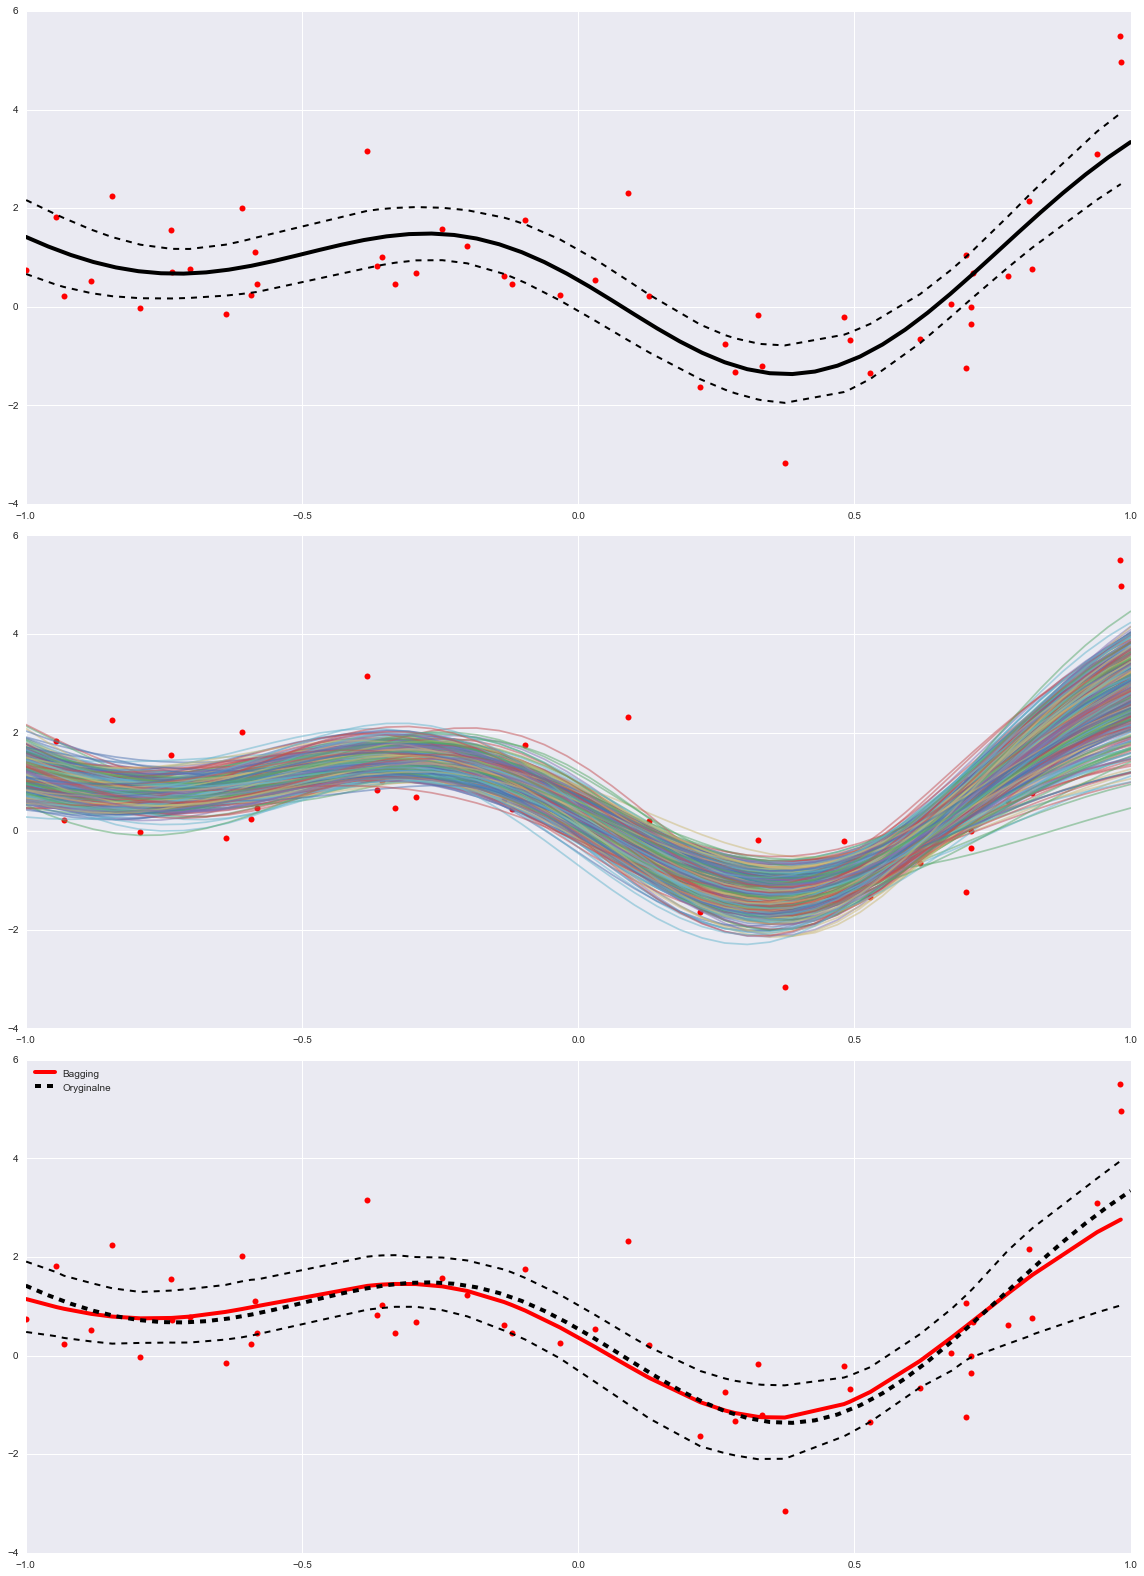

In [14]:
bootstrap_inference(n_gaussians=5, n_exmpl=50, std=0.75, bootstrap_runs=500)

## Bagging


* losowanie botstrap może służyć do polepszenia jakości estymacji
  * średnia bootstrap jest bliska średniej wartosci posterior
  
* __Bootstrap aggregation__ (__bagging__) uśrednia wynikiestymacji modeli zbudowanych na zbiorach bootstrap 
$$\boxed{\hat{f}_{bag}(x)=\sum_{b=1}^B\hat{f}^{*b}(x)
\;}$$
  * to estymacja Monte Carlo prawdziwej wartości bagging dla $B\longrightarrow\infty$
  * bagging dla modeli predykcji, oryginalnie zwracających tylko etykietę odpowiedzi (np. drzew), pozwala uzyskać estymację __prawdopodobieństwa__ klasy wyjsciowej

## Uśrednianie modeli


* bagging często pozwala na zredukowanie błędu kwadratowego
* mamy też inne sposoby __skladania__ modeli
  * mamy $K$ modeli $\mathcal{M}_k\;k=1,\dots,K$ dla zbioru danych $D$
  * modele mogą być 
    * __tego samego typu__ ale z __różnymi__ parametrami
    * __różnych typów__ dla __tego samego__ zadania
  * niech $z$ będzie jakąś interesującą nas wartością (predykcją w punkcie x, statystyką, etc.)
  $$P(z|D)=\sum_{k=1}^K P(z|\mathcal{M}_k,D)P(\mathcal{M}_k|D)$$
  z wartością oczekiwaną
  $$E(z|D)=\sum_{k=1}^K E(z|\mathcal{M}_k,D)P(\mathcal{M}_k|D)$$


  * predykcja jest __ważoną__ średnią pojedynczych predykcji __proporcjonalną__ do prawdopodobieństwa każdego modelu (zależnego od zbioru danych, _posterior_)
  
  
### Komitety maszyn
* __Komitety maszyn__ biorą __prostą średnią__ (z równym prawdopodobieństwem każdego modelu)
* możemy użyć jakiejś miary oceniającej prawdopodobieństwo/jakość modelu
  * preferując modele mniej złożone można np. uzyc miary __BIC__ (__Bayesian Information Criterion__)
  $$BIC=\frac{N}{\sigma_{\epsilon}^2}\sum_i(y_i-\hat{f}(x_i))^2+(\log N)d$$
  gdzie $d$ jest liczbą __parametrów__ modelu (np. liczbą funkcji bazowych)
* uśrednianie modeli (w każdym razie dla regresji) __nigdy__ nie pogarsza wyników, w każdym razie dla estymacji na pełnym rozkładzie danych
  * ten nie jest dostępny...
  * zwykle zabezpiecza przed złym łączeniem wzięcie pod uwagę złożoności modeli
* dla modeli klasyfikacji konieczne jest, by __nie__ uśredniać modeli __złych__ (gorszych od losowych)
  * pojęcie __modeli słabych__
  
  

### Stacking
* __Stacked generalization__ (__stacking__)
  * wzięcie pod uwagę złożoności modeli traktowaną jako __namierne dopasowanie__
  * niech $\hat{f}^{-i}_k(x)$ będzie estymacją $k$-tego modelu uczonego dla danych __bez__ przykładu $x_i$
  * __stacking__ wybiera modele o najlepszym błędzie kwadratowym 
  $$\boxed{\begin{align}
  \hat{f}^{stck}&=\sum_k w_k^{stck}\hat{f}_k(x)\\
  w^{stck}&=\underset{w}{\arg\min}\sum_{i=1}^N\left[y_i-\sum_{k=1}^K w_k\hat{f}_k^{-i}(x_i)\right]^2
  \end{align}\;}$$
  * stacking daje mniejsze wagi modelom, które słabo generalizują
  * wykorzystanie walidacji krzyżowej
    * wagi powinny się sumować do jedności
    * wagi powinny być nieujemne
  * ten model łączenia można wykorzystać dla różnych typów modeli
    * możliwe jest też rozdzielanie przestrzeni wejściowej i wybór osobnych modeli
    
    
### Bumping
* celem jest ominięcie __ewidentnie złych__ modeli
  * algorytm pzegląda przestrzeń wejściową generując zbiory _bootstrap_
  * dla każdego tworzy model i ocenia
    * zamiast uśredniać modele, __wybiera najlepszy__ uśredniony dla wszystkich danych
    $$\boxed{
    \hat{b}=\underset{b}{\arg\min}\sum_{i=1}^N(y_i-\hat{f}^{*b}(x_i))^2
    \;}$$
    * to pozwoli zabezpieczyć się przed wpływem danych ewidentnie psujących wybór modelu
* modele powinny mieć podobną złożoność
  * w przeciwnym wypadku procedura wybierze najlepiej dopasowany do danych uczących
* można łączyć z innymi procedurami

# Modele addytywne


* __modele addytywne__ są zdefiniowane jako
$$E(Y|X_1,\dots,X_L)=c+f_1(X_1)+f_2(X_2)+\dots+f_l(X_L)$$
  * $X_j$ są zmiennymi wyjaśniającymi
  
* regresja logistyczna dla problemu binarnego ma postać
$$\log\left(\frac{y(X)}{1-y(X)}\right)=c+\theta_1X_1+\dots+\theta_L X_L,$$
gdzie $y(X)=P(Y=1|X)$
* __addytywna__ regresja logistyczna będzie miała postać
$$\log\left(\frac{y(X)}{1-y(X)}\right)=c+f_1(X_1)+\dots+f_L(X_L)$$


* model addytywny ma postać $$Y=c+\sum_{l=1}^Lf_l(X_j)+\epsilon$$
($\epsilon$ jest szumem)

<!-- * uczenie modeli addytywnych
  1. inicjalizacja $$c=\frac{1}{N}\sum_i^Ny_i\\\hat{f}_l=0$$
  2. __repeat__
    * __for__ l __in__ range(L)
    $$\begin{align}
    \hat{f}_l
    \end{align}$$ -->

# Boosting
* czy możliwe jest połączenie wielu _słabych_ klasyfikatorów bazowych dla utworzenia modelu o dobrej zdolności predykcji
* niech $G()$ będzie binarnym klasyfikatorem i $$err=\frac{1}{N}\sum_{i=1}^NI(y_i\neq G(x_i)$$
będzie jego błędem nauczania
* __słaby klasyfikator__ to taki, którego oczekiwany błąd jest __niewiele lepszy__ od klasyfikatora losowego


* __Boosting__ buduje sekwencję $G_k(x)$ słabych klasyfikatorów do cały czas modyfikowanych danych dając końcową predykcję
$$\boxed{
G(x)=sign\left(\sum_{k=1}^K\alpha_kG_k(x)\right)
\;}$$
  * $\alpha_k$ są wagami słabych klasyfikatorów __ odpowiadającymi ich jakości
  * zbiory danych są modyfikowane tak, by __skupić uczenie__ na przykładach trudniejszych
  * to powoduje też, że poszczególne modele stają się __ekspertami__ dla pewnych podobszarów danych
  * boosting skupia się na etapie uczenia, co nie musi powodować minimalizacji oczekiwanego błędu testowania

## algorytm uczenia AdaBoost.M1

1. inicjalizacja __wag przykładów__ na $w_i=1/N$
2. for $k$ in range($K$):
  1. zbuduj klasyfikator $G_k(x)$ dla aktualnych danych wykorzystujących wagi $w_i$
    * przykłady w trakcie uczenia są __losowane__ zgodnie z rozkładem wag $w$
  2. oblicz aktualny błąd uczący $G_k()$ $$err_k=\frac{\sum_{i=1}^Nw_iI(y_i\neq G_k(x_i))}{\sum_{i=1}^Nw_i}$$
  3. oblicz współczynnik istotności $\alpha_k$ modelu $$\alpha_k=\ln((1-err_k)/err_k)$$ jako funkcję __logit__
  4. zmodyfikuj wagi przykładów $$w_i=w_i\cdot\exp(\alpha_k\cdot I(y_i\neq G_k(x_i)))$$
    * jeśli $x_i$ był __źle rozpoznawany__ przez $G_k()$, to waga $x_i$ jest zwiększana
    * jeśli $x_i$ był poprawnie rozpoznawany, to waga jest zmniejszana
    * wektor wag jest znormalizowany
3. zwróć model końcowy $$G(x)=sign\left[\sum_{k=1}^K\alpha_k G_k(x)\right]$$


* nawet bardzo słabe klasyfikatory moą dojść do wysokiej skuteczności
* AdaBoost jest modelem addytywnym
  * Adaboost jest modelem
    * __krokowym__ bo w każdym etapie optymalizuje tylko ze względu jedną parę parametrów, tj. $\alpha_k, G_k$ 
    * __zachłannym__ bo nie __nie zmienia__ poprzednich $\alpha_j, G_j;\;\;j=1,\dots,k-1$
  * lepszy byłby model optymalizujący wszystkie, to jednak byłoby zbyt złożonym problemem optymalizacyjnym

In [177]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

In [10]:
def adaboost():
    Xa, ya = make_gaussian_quantiles(mean=(1, 1), cov=1.5, n_samples=500, 
                                     n_features=2, n_classes=2)
    Xb, yb = make_gaussian_quantiles(mean=(2, 3), cov=2.0, n_samples=500, 
                                     n_features=2, n_classes=2)
    X = np.concatenate((Xa, Xb))
    y = np.concatenate((ya, -yb +1))
    fc = (y > 0)
    sc = (y < 1)
    fig, ax = plt.subplots(figsize=(18, 16))
    ax.plot(X[fc, 0], X[fc, 1], '.', ms=14)    
    ax.plot(X[sc, 0], X[sc, 1], '.', ms=14)
    
    tree = DecisionTreeClassifier(max_depth=1)
    # dummy = DummyClassifier(strategy='prior')
    adab = AdaBoostClassifier(tree, n_estimators=200)
    adab.fit(X, y)
    
    h = 0.01
    ext = 0.25
    x_min, x_max = X[:, 0].min() - ext, X[:, 0].max() + ext
    y_min, y_max = X[:, 1].min() - ext, X[:, 1].max() + ext
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = adab.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

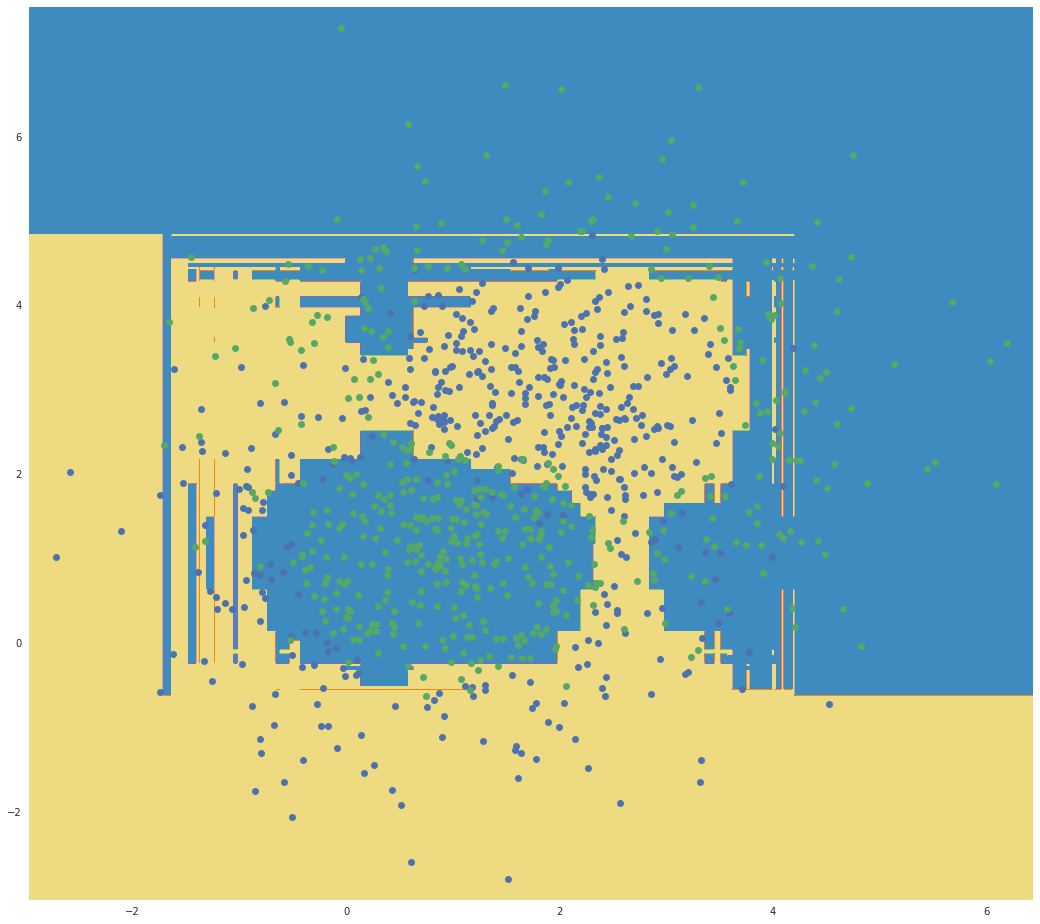

In [61]:
adaboost()

## Adaboost


* Adaboost jest modelem __addytywnym__
  * w kolejnych krokach buduje zestaw __funkcji bazowych__ 
  * popularne w 
    * sieciach neuronowych (sparametryzowane __cechy__ wykrywane w warstwach ukrytych), 
    * przetwarzaniu sygnałów gdzie budowane są kolejne funkcje w oparciu o funkcje falkowe, 
    * drzewach decyzyjnych gdzie wybierane są zmienne dzielące (testy)
    
    
1. inicjalizacja $f_0(x)=0$
2. dla kolejnych modeli $k=1,\dots,K$
  1. $$(\beta_k, \theta_k)=\underset{\beta,\theta}{\arg\min}\sum_{i=1}^NL(y_i, f_{k-1}(x_i)+\beta h(x_i;\theta)),$$
  gdzie $h(x_i;\theta)$ jest funkcją bazową sparametryzowaną $\theta$
  2. $$f_k(x)=f_{k-1}(x)+\beta_k h(x;\theta)$$
  
  
* dla błędu kwadratowego w kolejnym kroku poprawiania
$$\begin{align}
L(y_i, f_{k-1}(x_i)+\beta h(x_i;\theta))&=(y_i-f_{k-1}(x_i)-\beta h(x_i;\theta))^2\\
&=(r_{ik}-\beta h(x_i;\theta))^2
\end{align}$$
a więc kolejny krok __minimalizuje__ residuum błędu aktualnego $(k-1)$-szego modelu!
  * jednak błąd kwadratowy nie jest najlepszym wyborem dla klasyfikacji

### Funkcja kosztu w  Adaboost

* okazuje się, że Adaboost.M1 jest __równoważny__ algorytmowi krokowego addytywnego modelowania dla funkcji kosztu __exponential loss__
$$\boxed{L(y, f(x))=\exp(-yf(x))\;}$$
  * 
* używając eksponencjalnej funkcji loss dostajemy do minimalizacji w kroku addytywnego algorytmu
$$\begin{align}
(\beta_k,G_k)&=\underset{\beta,G}{\arg\min}\sum_i^N\exp[-y_i(f_{k-1}(x_i)+\beta G(x_i))]\\
&=\underset{\beta,G}{\arg\min}\sum_i^N\exp[-y_if_{k-1}(x_i)]\exp[-\beta y_i G(x_i))]\\
&=\underset{\beta,G}{\arg\min}\sum_i^Nw_i^{(k)}\exp[-\beta y_i G(x_i))]\tag{*}\\
&\text{gdzie $w_i^{(k)}=\exp[-y_if_{k-1}(x_i)]$ jest niezależne od $\beta$ i $G$}
\end{align}$$
* Optymalnym $G$ jest ten, który popełnia __najmniej__ błędów na ważonym przez $w_i^{(k)}$ zbiorze
$$G_k=\underset{\beta,G}{\arg\min}\sum_i^Nw_i^{(k)}I(y_i\neq G(x_i))$$
  * w tym kroku $\alpha$ jest traktowane jako ustalone i minimalizowany jest model ze względu na funkcję bazową $G$
  * wagi $w$ __nie zależą__ od $\alpha$ ani od $G$, stąd traktowane są jako związane z przykładami
  
  
  
* rozwijając $(*)$ rozbijając na przykłady dobrze i źle klasyfikowane i pamiętając, że $y_i\in\{-1,+1\}$
$$\begin{align}
&\sum_i^Nw_i^{(k)}\exp[-\beta y_i G(x_i))]\\
=&\sum_{y_i=G(x_i)}w_i^{(k)}\exp(-\beta)+\sum_{y_i\neq G(x_i)}w_i^{(k)}\exp(\beta)\tag{**}\\
&\text{dla niepoprawnych $y_iG(x_i)=-1$, dla poprawnych $y_iG(x_i)=+1$}\\
=&\underbrace{e^{-\beta}\sum_{y_i=G(x_i)}w_i^{(k)}+e^{-\beta}\sum_{y_i\neq{}G(x_i)}w_i^{(k)}}\underbrace{-e^{-\beta}\sum_{y_i\neq{}G(x_i)}w_i^{(k)}+e^{\beta}\sum_{y_i\neq{}G(x_i)}w_i^{(k)}}\\
=&e^{-\beta}\sum_{i=1}^Nw_i^{(k)}+[e^{\beta}-e^{-\beta}]\sum_{i=1}^Nw_i^{(k)}I(y_i\neq{}G(x_i))
\end{align}$$
  * w pierwszym składniku kara $e^{-\beta}$ odnosi się do wszystkich przykladow i nie ma wplywu na rozwiązanie
  * w drugim składniku mamy karę dla przykladów źle klasyfikowanych
  
  
  
* równanie (**) można zapisać jako $$e^{-\beta}(1-err)+e^{\beta}err$$ gdzie $err_k$ jest ważonym błędem klasyfikatora $G_k$  
  * różniczkując po $\beta$ i przyrównując do $0$
  $$\begin{align}
  -e^{-\beta}(1-err)+e^{\beta}err&=0\\
  -(1-err)+e^{2\beta}err&=0\\
  e^{2\beta}&=\frac{1-err}{err}
  \end{align}$$
  skąd optymalne $\alpha_k$ i $\beta_k$ 
$$\boxed{\alpha_k=2\beta_k=\ln\frac{1-err_k}{err_k}}$$ 
* nowe wagi przykladów mają postać
$$\boxed{w_i^{(k+1)}=w_i^{(k)}\cdot{}e^{\alpha_kI(y_i\neq{}G_k(x_i))}\cdot{}e^{-\beta_k}\;}$$
gdzie składnik $e^{-\beta}$ jest czynnikiem __normalizującym__



* Yoav Freund i Robert Schapire otrzymali nagrodę G{\"o}dla za propozycję tego algorytmu w 2003 roku

In [204]:
def loss_functions():
    fig, ax = plt.subplots(figsize=(16, 12))
    x = np.linspace(-2.0, 2.0, 1000)
    misclass = np.sign(-x) / 2. + 0.5
    exp_loss = np.exp(-x)
    c = 1./np.log(1.+np.exp(-0))
    binom = c * np.log(1. + np.exp(-2 * x))
    squared = (1. - x) ** 2
    svm = np.maximum(0, (1. - x))
    ax.plot(x, misclass, label=r'błędna klasyfikacja')
    ax.plot(x, exp_loss, label='eksponencjalna')
    ax.plot(x, binom, label='binomialna')
    ax.plot(x, squared, label='kwadratowa')
    ax.plot(x, svm, label='svm')
    ax.set_xlim([-2., 2.])
    ax.set_ylim([0, 6.0])
    ax.legend(loc=0)

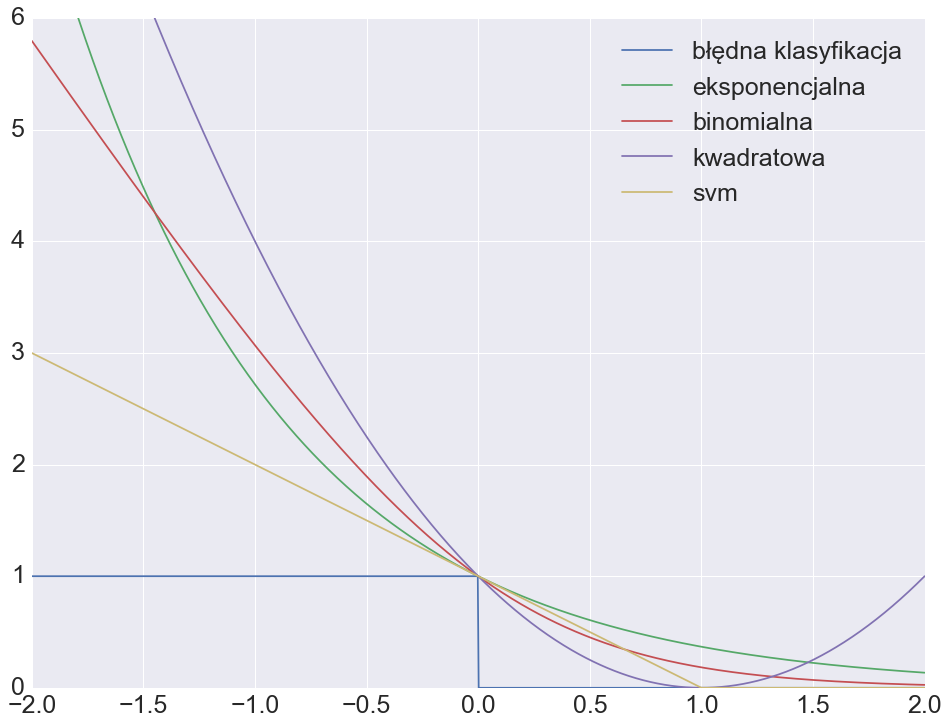

In [205]:
loss_functions()

## Funkcje kosztu
* czemu __eksponencjalna funkcja__ kosztu?
  * dla binarnego problemu ($y\in\{-1,+1\}$) mamy
  $$E[exp(-yf(x)]=P(y=-1|x)exp(-f(x))+P(y=+1|x)exp(f(x))$$
  * i znowu różniczkując __ze względu na $f$__ dostajemy optymalne $f^{*}$
  $$\boxed{f^{*}(x)=\underset{f}{\arg\min}E[exp(-yf(x))]=\frac{1}{2}\ln\frac{P(y=1|x)}{P(y=-1|x)}\;}$$
  gdzie składnik $\displaystyle \ln\frac{P(y=+1|x)}{P(y=-1|x}$ jest znany jako __log-odds__



* eksponencjalna funkcja loss pozwala na prostą metodę modyfikacji wag modelu
* addytywny model Adaboost  estymuje log-odds $P(Y=1|X)$ $$f^{*}(x)=\frac{1}{2}\ln\frac{P(Y=1|X)}{1-P(Y=1|X)}$$

* pojęcie __marginesu__
  * __dodatni__ dla $y_if(x_i)>0$
  * __ujemny__ dla $y_if(x_i)<0$
  * punkty źle klasyfikowane (z marginesu ujemnego)) są karane silniej niż te klasyfikowane poprawnie (margines dodatni)
* podobnie funkcja binomialna $$L(Y,f)=\log(1+\exp(-2yf))$$
  
* eksponencjalna $\log(-yf(x))$ i binomialna $\log(1+\exp(-2yf(x))$ karzą dla negatywnego marginesu
  * stopień w jakim eksponencjalna funkcja karze przykłady źle klasyfikowane i odległe od płaszczyzny jest __wykładniczo__ wysoki
    * szum, outliers, mają zbyt duży wpływ na postać rozwiązania
  * binomialna robi to w mniejszym stopniu
    * wzrost wartości karzącej dla ujemnego marginesu jest prawie liniowy
    * ta funkcja należy do kategorii funkcjii __odpornych na szum__
    * jednak optymalizacja jest bardziej złożona i wymaga metod gradientowych
  * skuteczność Adaboost gwałtownie spada w przypadku dużego szumu
    * szczególnie dla błędnych etykietowań

### Rozszerzenia i uwagi do Adaboost
* istnieją rozszerzenia dla problemów wieloklasowych
* także zastosowanie regularyzacji


* co ciekawe, gdy błąd Adaboost maleje do zera, algorytm jest typowo __odporny
na przeuczenie__!
  * to wciąż żywy obszar badań

### Siła różnych modeli (według Hastie et al.)

|   | Sieci neuronowe | SVM | Drzewa | k-NN, metody jądrowe  |
|---|---|---|---|---|
| dane różnych typów | -- | -- | ++  | --  |
| przetwarzanie brakujących zmiennych | -- | -- | ++ | ++ |
| odporność na outliers | -- | -- | ++ | ++ |
| odporność na monotoniczne transformacje dnaych | -- | -- | ++ | -- |
| skalowalność obliczeń | -- | -- | ++ | -- |
| zdolność przetwarzania nieistotnych zmiennych | -- | ++ | ++ | -- |
| zdolność ekstrakcji kombinacji liniowych cech | ++ | ++ | -- | oo |
| interpretowalność | -- | -- | oo | -- |
| siła generalizacji | ++ | ++ | -- | ++ |


## Boosting drzew
* drzewa decyzyjne można zapisać jako $$T(x,\theta)=\sum_{k=1}^K\gamma_l I(x\in R_l)$$ gdzie
  * $R_l$ jest końcowym obszarem odpowiadającym liściu w drzewie
  * $\gamma_l$ jest wartością funkcji w liściu (średnia, mediana, etc)
  * drzewa budujemy w dwóch krokach optymalizując $$\hat\theta=\underset{\theta}{\arg\min}\sum_{l=1}^L\sum_{x_i\in R_l}L(y_i, \gamma_l)$$
    * szukanie obszarów $R_l$ zwykle jest robione jakimś zachłannym algorytmem
    * dla znalezionego obszaru optymalizujemy wartość $\gamma_l$
    
    
    
* w procesie boostingu można zbudować __wzmocnione__ (boosted) drzewa jako sumę indywidualnych drzew $$f_K(x)=\sum_{k=1}^KT(x; \theta_k)$$
  * drzewa budowane są w procesie __krokowego modelu addytywnego__ optymalizując w każdym kroku 
  $$\boxed{
  \hat\theta_k=\underset{\theta_k}{\arg\min}\sum_{i=1}^NL(y_i, f_{k-1}(x_i)+T(x_i,\theta_k))
  \;}$$
  * dla znalezionych obszarów $R_{lk}$ potrzebna jest wartość 
  $$\hat\gamma_{lk}=\underset{\gamma_{lk}}{\arg\min}\sum_{x_i\in R_{lk}}L(y_i, f_{k-1}(x_i)+\gamma_{lk})$$
  * takie drzewo $T_k()$ __minimalizuje błędy modelu zbudowanego do tego momentu__
    * dla błędu średniokwadratowego
      * drzewo przewiduje dotychczasowe błędy $y_i+f_{k-1}(x_i)$, a $\gamma_{lk}$ jest średnią w danym obszarze
    * dla błędu eksponencjalnego i problemów binarnych
      * rozwiązanie odpowiada algorytmowi Adaboost
      * rozwiązanie jest drzewem $\beta_kT(x;\theta_k)$
      * drzewo minimalizuje ważony błąd $\sum_{i=1}^Nw_i^{(k)}I(y_i\neq T(x_i,\theta_k))$
    * uzycie funkcji odpornej na outliers daje zwykle dość złożony algorytm poszukiwania obszarów

### Rozmiar drzew
* podejście krokowe zakłada, że budowane drzewo jest __ostatnie__
  * to jest prawdziwe tylko przy rzeczywiście ostatnim drzewie w złożonym modelu
  * w efekcie większość drzew jest za duża
  * to powoduje zbytnie dopasowanie i obniża poziom generalizacji
    * także jest kosztowne obliczeniowo
    
    
* jaki powinien być rozmiar drzew?
  * __ograniczenie rozmiaru wszystkich drzew do__ $K$
    * $K=2$: wszystkie drzewa zbudowane są na teście __co najwyżej jednego__ atrybutu
    * $K=3$ co najwyżej __dwóch__ atrybutów
    * $K=4$ co najwyżej __czterech__ atrybutów
    * i tak dalej
    * zwykle $K\in[4, 8]$ daje dobre rezultaty, rzadko wyniki poprawiają się dla $K>6$
    * zwykle większe $K$ wprowadza większą wariancję i wyższy błąd

## Regularyzacja modeli boostowanych drzew
* każde kolejne drzewo ma za zadanie redukcję dotychczasowego błędu
  * dowolnie duża liczba drzew może zredukować błąd całkowicie
  * jednak to doprowadzi do __nadmiernego dopasowania__
  * konieczne jest ograniczenie liczby drzew i redukcja ich wpływu na błąd
  
  
### Ograniczanie wpływu drzew
* nowo dodane drzewo zredukuje błąd
* dobrym podejściem do regularyzacji będzie __ograniczanie wpływu redukcji__
$$\boxed{
f_k(x)=f_{k-1}(x)+\nu\cdot\sum_{l=1}^L\gamma_{lk}I(x\in{}R_{lm})
\;}$$
  dla $0<\nu<1$
  * redukcja $\nu$ i liczba drzew w modelu $K$ __nie są niezależne__
    * mniejsze $\nu$ wymaga większego $K$
    * najlepszym rozwiązaniem jest zazwyczaj bardzo małe $nu\approx0.1$ i całkowita liczba drzew $K$ wybierana pod kontrolą
      * na przykład wczesne zatrzymywanie z wykorzystaniem zbioru walidującego

      


### Próbkowanie zbioru uczącego
* uśrednianie szeregu zaszumionych klasyfikatorów ogranicza wariancję modelu
* __próbkowanie danych uczących__
  * w każdej iteracji wybierany jest fragment danych, zwykle około połowy
    * dla dużego zbioru danych można wybać nawet mniej
  * uzyskany model jest dokładniejszy
    * poszczególne modele bazowe (drzewa) są bardziej zaszumione
  * także zyski obliczeniowe
  
* próbkowanie __wymaga równoczesnego ograniczania wpływu kolejnych modeli__
  * samo próbkowanie często daje słabe wyniki


* tworzenie modelu wymaga teraz ustalenie większej liczby parametrów
  * liczby modeli $K$
  * liczby obszarów (liści) generowanych przez każdy z nich $L$
  * parametru ograniczania $\nu$
  * parametru próbkowania $\eta$

### Istotność zmiennych wyjaśniających
* dla pojedynczych drzew Breiman zaproponował miarę istotności zmiennej $p$ 
$$Imp^2(p;T)=\sum_{t=1}^{J-1}g_t^2 I(v(t)=p)$$
  * suma po wszystkich $J-1$ węzłach wewnętrznych
  * dla każdego wewnętrznego węzła jest wybierana zmienna $X_{v(t)}$ powodująca największy zysk w postaci __redukcji błędu__ $g$ wynikającej z podziału węzła
  * w efekcie $Imp(p;T)$ jest sumą zysków wynikających z wyboru zmiennej wyjaśniającej $X_p$
  * miarę skalujemy tak, by największa istotność miała ustaloną wartość, np. 100
  
  
* dla komitetu drzew miarę można rozszerzyć jako
$$Imp^2(p)=\frac{1}{K}\sum_{k=1}^K Imp^2(p;T_k)$$


In [200]:
def importance(n_estimators = 30):
    with open('breast-cancer-wisconsin.tab', 'r') as f:
        data = np.genfromtxt(f, delimiter='\t')
    X = data[3:, :-1]
    y = data[3:, -1]
    names = ['clump', 'cell size', 'cell shape', 'marginal adh', 
             'sinigle cell size', 'bare nuclei', 'bland', 'normal nuclei', 'mitoses']
    fig, ax = plt.subplots(1, 3, figsize=(20,14))
    ensemble_name = ('ExtraTreesForest', 'RandomTreesForest', 'GradientBoosting')
    sns.set(font_scale=2.5)
    for k, forest in enumerate([ExtraTreesClassifier(n_estimators=n_estimators, 
                                                    random_state=0),
                               RandomForestClassifier(n_estimators=n_estimators, 
                                                      random_state=0),
                               GradientBoostingClassifier(n_estimators=n_estimators)]):
        forest.fit(X, y)
        imp = forest.feature_importances_
        ind = np.argsort(imp)[::-1]
        ax[k].set_title(ensemble_name[k])
        sns.barplot(imp[ind], range(X.shape[1]), hue=[names[i] for i in ind], orient='h', ax=ax[k])
    fig.tight_layout()

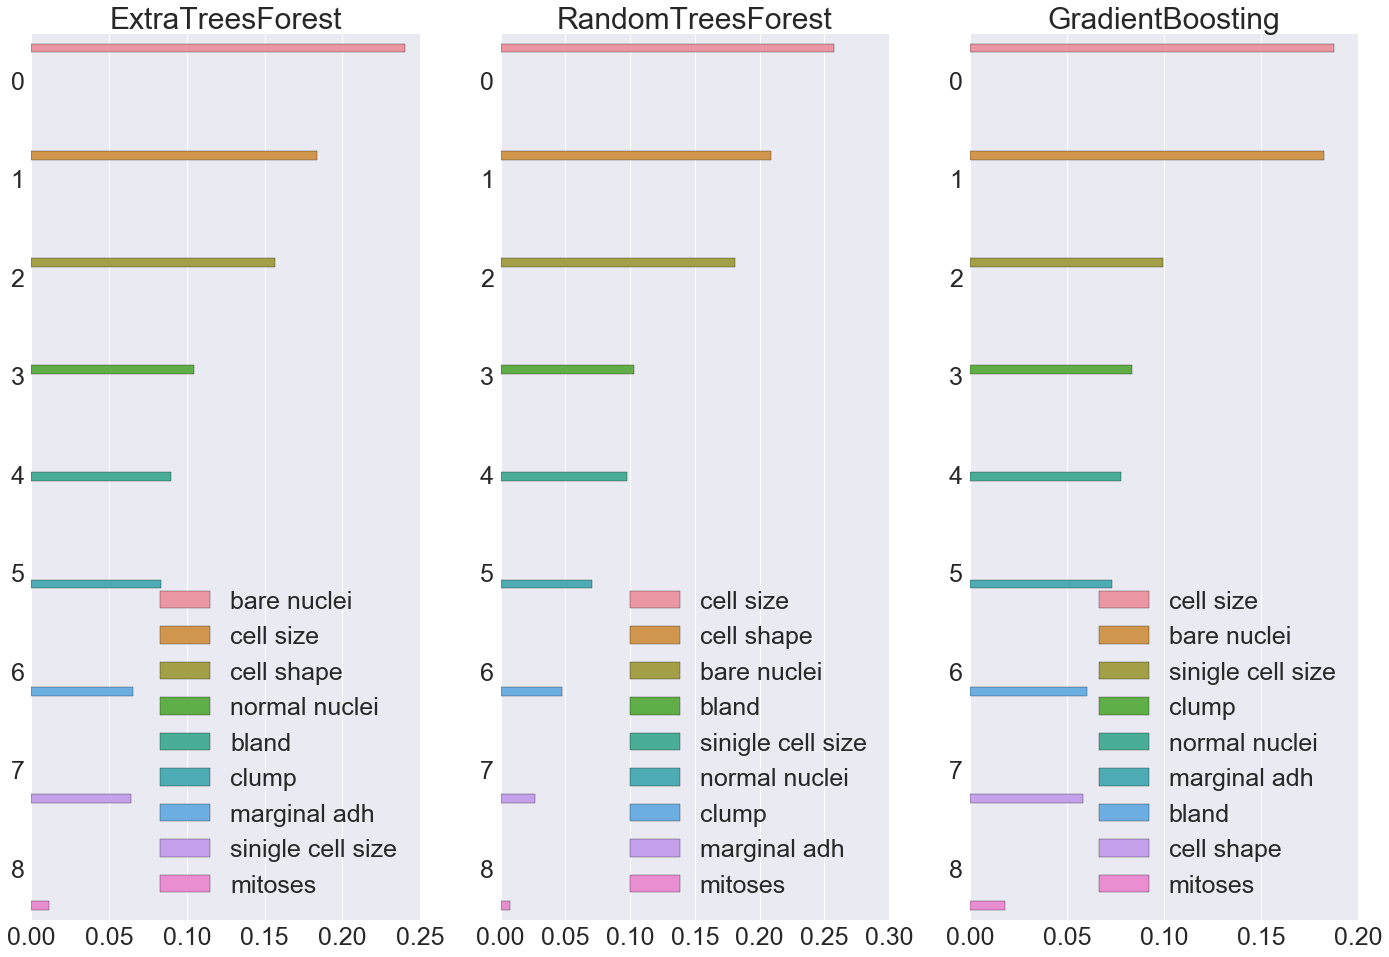

In [201]:
importance(n_estimators=500)